Alice's Original Key:      [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]
Alice's Bases:            ['+', '+', '+', 'x', '+', '+', 'x', 'x', 'x', '+', '+', '+', '+', 'x', '+', '+', 'x', '+', '+', 'x']
Bob's Measured Key:       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Bob's Bases:              ['x', '+', '+', '+', '+', 'x', '+', '+', '+', 'x', 'x', '+', 'x', 'x', 'x', '+', 'x', 'x', 'x', '+']

Number of Matching Bases:  7
Shared Key (Alice):       [1, 1, 1, 0, 1, 0, 1]
Shared Key (Bob):         [0, 0, 0, 0, 0, 0, 0]


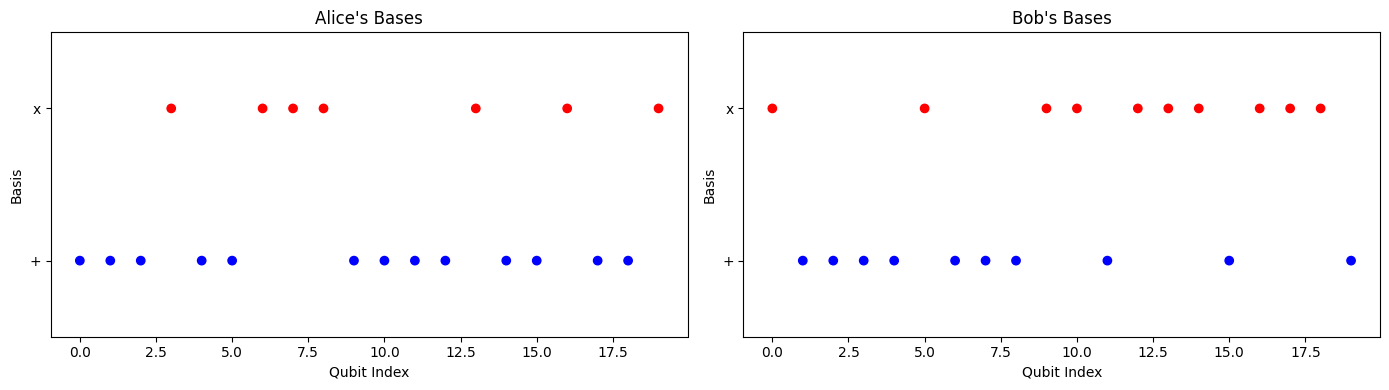

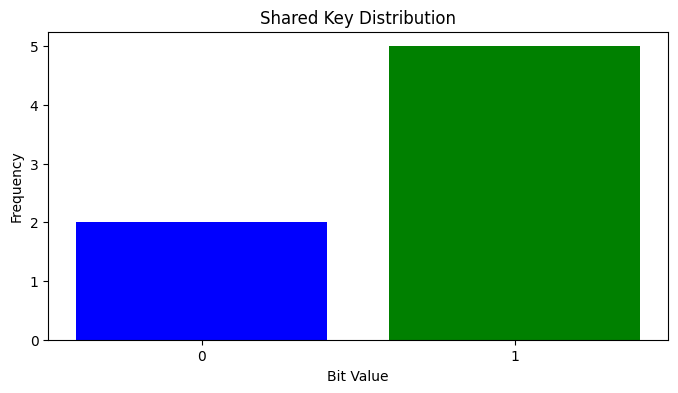

In [1]:
#-------------------------------------------------------------------------
# BB84 Quantum Key Distribution Simulation using Qiskit
# Chapter 10 in the QUANTUM COMPUTING AND QUANTUM MACHINE LEARNING BOOK
#-------------------------------------------------------------------------
# Version 1.1
# (c) 2025 Jesse Van Griensven, Roydon Fraser, and Jose Rosas 
# Licence: MIT - Citation required
#-------------------------------------------------------------------------
# Qiskit changes frequently. 
# We recommend using the latest version from the book code repository at:
# https://github.com/pedroer/quantum-computing-for-engineers/blob/main/requirements.txt

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import random
import warnings
warnings.filterwarnings('ignore')

#-------------------------------------------------------------------------
def generate_random_bits(n):
    """Generate a list of n random bits (0 or 1)."""
    return [random.randint(0,1) for _ in range(n)]

def generate_random_bases(n):
    """Generate a list of n random bases ('+' for rectilinear, 'x' for diagonal)."""
    return [random.choice(['+', 'x']) for _ in range(n)]

def encode_qubit(bit, basis):
    """Encode a bit into a qubit using the specified basis."""
    qc = QuantumCircuit(1, 1)
    if basis == 'x':
        # Diagonal basis: Apply Hadamard gate first
        qc.h(0)
    if bit == 1:
        # If bit is 1, apply X gate to flip |0> to |1>
        qc.x(0)
    return qc

def measure_qubit(qc, basis):
    """Measure a qubit using the specified basis."""
    if basis == 'x':
        # Diagonal basis: Apply Hadamard gate before measurement
        qc.h(0)
    qc.measure(0, 0)
    return qc

def simulate_bb84(n_bits=20, error_rate=0.0):
    """
    Simulate the BB84 QKD protocol.

    Parameters:
    - n_bits: Number of bits to encode and transmit.
    - error_rate: Probability of a bit flip error occurring during transmission.
    
    Returns:
    - key_alice: Alice's original key.
    - bases_alice: Alice's chosen bases.
    - key_bob: Bob's measured key before basis reconciliation.
    - bases_bob: Bob's chosen bases.
    - key_shared: Final shared key after basis reconciliation.
    - key_bob_shared: Bob's shared key after basis reconciliation.
    - matching_bases: Indices where Alice's and Bob's bases matched.
    """
    # Step 1: Alice generates a random key and basis
    key_alice = generate_random_bits(n_bits)
    bases_alice = generate_random_bases(n_bits)
    
    # Step 2: Alice encodes the qubits
    qc_total = QuantumCircuit(n_bits, n_bits)
    for i in range(n_bits):
        qc_qubit = encode_qubit(key_alice[i], bases_alice[i])
        # Append Alice's qubit to the total circuit
        qc_total.compose(qc_qubit, qubits=[i], inplace=True)
    
    # Step 3: Introduce transmission errors (simulated as bit flips)
    # For simplicity, we'll apply an X gate with probability equal to error_rate
    for i in range(n_bits):
        if random.random() < error_rate:
            qc_total.x(i)
    
    # Step 4: Bob generates his random basis choices
    bases_bob = generate_random_bases(n_bits)
    key_bob = []
    
    # Step 5: Bob measures the qubits
    for i in range(n_bits):
        qc_measure = measure_qubit(QuantumCircuit(1,1), bases_bob[i])
        qc_total.compose(qc_measure, qubits=[i], inplace=True)
    
    # Step 6: Execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc_total, simulator, shots=1, memory=True)
    result = job.result()
    measurements = result.get_memory()
    key_bob = [int(bit) for bit in measurements[0]]
    
    # Step 7: Basis Reconciliation
    # Alice and Bob publicly compare their bases
    matching_bases = [i for i in range(n_bits) if bases_alice[i] == bases_bob[i]]
    
    # Extract the shared key based on matching bases
    key_shared = [key_alice[i] for i in matching_bases]
    key_bob_shared = [key_bob[i] for i in matching_bases]
    
    return key_alice, bases_alice, key_bob, bases_bob, key_shared, key_bob_shared, matching_bases

def plot_bases(bases_alice, bases_bob):
    """Plot Alice's and Bob's bases choices."""
    # Convert bases to numerical values for plotting
    # '+' -> 0, 'x' -> 1
    bases_alice_num = [0 if b == '+' else 1 for b in bases_alice]
    bases_bob_num = [0 if b == '+' else 1 for b in bases_bob]
    
    plt.figure(figsize=(14, 4))
    
    # Plot Alice's Bases
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(bases_alice_num)), bases_alice_num, c=['blue' if b == '+' else 'red' for b in bases_alice], label='Alice')
    plt.title("Alice's Bases")
    plt.yticks([0,1], ['+', 'x'])
    plt.xlabel('Qubit Index')
    plt.ylabel('Basis')
    plt.ylim(-0.5, 1.5)
    
    # Plot Bob's Bases
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(bases_bob_num)), bases_bob_num, c=['blue' if b == '+' else 'red' for b in bases_bob], label='Bob')
    plt.title("Bob's Bases")
    plt.yticks([0,1], ['+', 'x'])
    plt.xlabel('Qubit Index')
    plt.ylabel('Basis')
    plt.ylim(-0.5, 1.5)
    
    plt.tight_layout()
    plt.show()

def main():
    # Number of bits to simulate
    n_bits = 20
    # Transmission error rate (e.g., 0.1 for 10% error rate)
    error_rate = 0.1
    
    # Simulate BB84
    key_alice, bases_alice, key_bob, bases_bob, key_shared, key_bob_shared, matching_bases = simulate_bb84(n_bits, error_rate)
    
    # Display results
    print("Alice's Original Key:     ", key_alice)
    print("Alice's Bases:           ", bases_alice)
    print("Bob's Measured Key:      ", key_bob)
    print("Bob's Bases:             ", bases_bob)
    print("\nNumber of Matching Bases: ", len(matching_bases))
    print("Shared Key (Alice):      ", key_shared)
    print("Shared Key (Bob):        ", key_bob_shared)
    
    # Plot Alice's and Bob's bases
    plot_bases(bases_alice, bases_bob)
    
    # Plot the shared key as a histogram (simple visualization)
    if key_shared:
        plt.figure(figsize=(8,4))
        plt.bar(['0', '1'], [key_shared.count(0), key_shared.count(1)], color=['blue', 'green'])
        plt.title("Shared Key Distribution")
        plt.xlabel("Bit Value")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print("No matching bases. No shared key generated.")

# Run the main function
if __name__ == "__main__":
    main()
